In [120]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm

In [121]:
def objectiveFunction(w,image):
    #compute the histogram
    #print('w in the objectiveFunction is ')
    #print(w)
    TotalNumberOfPixelsInImage = (image.shape[0])*(image.shape[1]) 
    NumberofPixelsPerIntensity = np.zeros(256)
    for i in range(0,256):
        NumberofPixelsPerIntensity[i] = np.sum(image==i)
    probDensity = NumberofPixelsPerIntensity/TotalNumberOfPixelsInImage
    #from w compute the lower and upper limits
    lowerLimit = 0
    upperLimit = 255
    tempSum = 0
    for i in range(0,256):
        tempSum += probDensity[i]
        if(tempSum>w):
            lowerLimit = i
            break
    tempSum = 0
    for i in range(0,256):
        tempSum += probDensity[255-i]
        if(tempSum>w):
            upperLimit = int(255-i)
            break
    if(lowerLimit==0 and upperLimit==0):
        lowerLimit = 0
        upperLimit = 255
    if(lowerLimit==upperLimit):
        print(w)
    #perform contrast stretching to map lower and upper limits to a and b
    a = 0
    b = 255
    factor = ((b-a)/(upperLimit-lowerLimit))
    transformedImage = np.round_(a+((image-lowerLimit)*factor))    
    #compute the histogram of transformed image
    NumberofPixelsPerIntensity = np.zeros(256)
    for i in range(0,256):
        NumberofPixelsPerIntensity[i] = np.sum(transformedImage==i)
    NewprobDensity = NumberofPixelsPerIntensity/TotalNumberOfPixelsInImage
    #compute the entropy
    NonZeroNewProbDensity = NewprobDensity[NewprobDensity>0]
    entropy = -1*np.sum(NonZeroNewProbDensity*np.log2(NonZeroNewProbDensity))
    #compute the average gradient
    dy,dx = np.gradient(transformedImage)
    avg_gradient = np.sum(np.sqrt((dy*dy)+(dx*dx)))/TotalNumberOfPixelsInImage
    #return sum of these
    return entropy+avg_gradient

In [122]:
a = np.array([3,0,8,0,10])
a[a >0 ]

array([ 3,  8, 10])

In [123]:
def DEAlgo1(image,objectiveFunction,MutationParameter = 0.8,crossp = 0.7, SizeOfPopulation = 20, iterations = 1000):
    minimumW = 0
    maximumW = 0.5
    Population = (minimumW + ((np.random.rand(SizeOfPopulation))*(maximumW - minimumW)))
    BestOfPopulationIndex = np.argmin(np.asarray([objectiveFunction(image,tempW) for tempW in Population]))
    BestOfPopulation = Population[BestOfPopulationIndex]
    for i in range(0,iterations):
        for j in range(0,SizeOfPopulation):
            ArrayWithoutIndexJ = np.delete(range(SizeOfPopulation),[j])
            #select three random elements from here
            r1,r2,r3 = Population[np.random.choice(ArrayWithoutIndexJ, 3, replace = False)]
            MutantVectorV = np.clip(r1 + MutationParameter * (r2 - r3), minimumW, maximumW)
            

In [130]:
def DEAlgo2(image,objectiveFunction,mut=0.8, crossp=0.7, popsize=40, its=1000):
    bounds =  [(0,0.4)]
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    pop_denorm = min_b + pop * diff
    fitness = np.asarray([objectiveFunction(ind,image) for ind in pop_denorm])
    best_idx = np.argmin(fitness)
    best = pop_denorm[best_idx]
    for i in tqdm(range(its)):
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace = False)]
            mutant = np.clip(a + mut * (b - c), 0, 1)
            cross_points = np.random.rand(dimensions) < crossp
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, pop[j])
            trial_denorm = min_b + trial * diff
            f = objectiveFunction(trial_denorm,image)
            if f < fitness[j]:
                fitness[j] = f
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial_denorm
    return best, fitness[best_idx]

In [131]:
def contrastStretching(image,w):
    #compute the histogram
    TotalNumberOfPixelsInImage = (image.shape[0])*(image.shape[1]) 
    NumberofPixelsPerIntensity = np.zeros(256)
    for i in range(0,256):
        NumberofPixelsPerIntensity[i] = np.sum(image==i)
    probDensity = NumberofPixelsPerIntensity/TotalNumberOfPixelsInImage
    #from w compute the lower and upper limits
    lowerLimit = 0
    upperLimit = 255
    tempSum = 0
    for i in range(0,256):
        tempSum += probDensity[i]
        if(tempSum>w):
            lowerLimit = i
            break
    tempSum = 0
    for i in range(0,256):
        tempSum += probDensity[int(255-i)]
        if(tempSum>w):
            upperLimit = int(255-i)
            break
    #perform contrast stretching to map lower and upper limits to a and b
    a = 0
    b = 255
    factor = ((b-a)/(upperLimit-lowerLimit))
    transformedImage = np.round_(a+((image-lowerLimit)*factor))
    return transformedImage

In [132]:
def EnhanceTheImage(GivenImage):
    BestWforEachChannel = np.zeros(3)
    for i in range(0,GivenImage.shape[-1]):
        BestWforEachChannel[i] = DEAlgo2(GivenImage[:,:,i],objectiveFunction)[0]
    EnhancedImage = np.zeros(GivenImage.shape)
    for i in range(0,GivenImage.shape[-1]):
        EnhancedImage[:,:,i] = contrastStretching(GivenImage[:,:,i],BestWforEachChannel[i])
    return EnhancedImage        

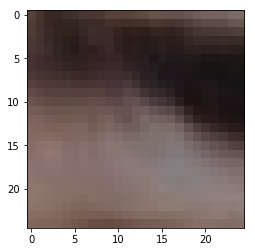

float64


In [133]:
GivenImage = cv2.imread("SampleImage1.jpg")
GivenImage = cv2.cvtColor(GivenImage, cv2.COLOR_BGR2RGB)
GivenImage = GivenImage[275:300,225:250]
GivenImage = GivenImage/255.0
GivenImage = GivenImage*255
plt.imshow(GivenImage/255)
plt.show()
print(GivenImage.dtype)

In [141]:
temp = EnhanceTheImage(GivenImage)

In [142]:
print(temp)

[[[132. 112.  94.]
  [101.  81.  62.]
  [ 72.  54.  34.]
  ...
  [195. 188. 172.]
  [210. 204. 188.]
  [210. 204. 188.]]

 [[121.  98.  85.]
  [ 97.  76.  60.]
  [ 72.  51.  39.]
  ...
  [148. 136. 119.]
  [167. 157. 140.]
  [167. 161. 145.]]

 [[117.  98.  83.]
  [ 97.  78.  67.]
  [ 72.  58.  44.]
  ...
  [105.  94.  76.]
  [113. 103.  85.]
  [115. 110.  90.]]

 ...

 [[243. 224. 198.]
  [241. 221. 195.]
  [236. 217. 195.]
  ...
  [247. 242. 234.]
  [245. 239. 232.]
  [245. 246. 241.]]

 [[230. 212. 181.]
  [232. 208. 179.]
  [228. 201. 177.]
  ...
  [245. 237. 225.]
  [230. 221. 209.]
  [234. 228. 221.]]

 [[218. 199. 168.]
  [216. 190. 161.]
  [216. 190. 161.]
  ...
  [224. 206. 193.]
  [220. 208. 193.]
  [222. 208. 198.]]]


In [144]:
temp.shape

(25, 25, 3)

In [160]:
np.linalg.norm(GivenImage[:,:,1] - temp[:,:,1])

1863.2949310294384

In [151]:
temp1 = temp[:,:,0]
temp2 = temp[:,:,1]
temp3 = temp[:,:,2]

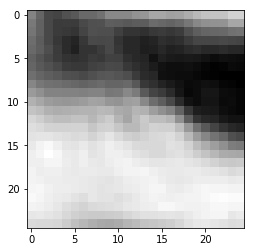

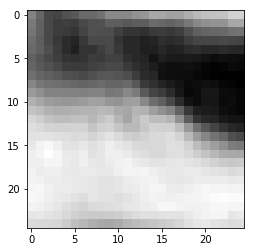

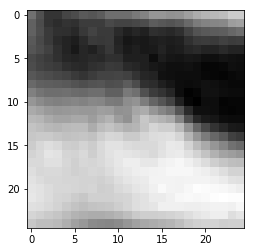

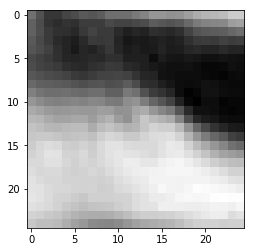

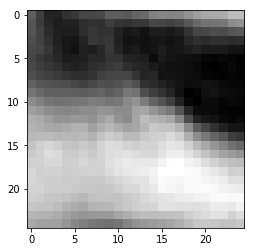

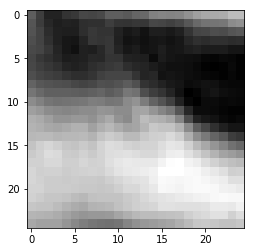

In [159]:
for i in range(0,3):
    plt.imshow(GivenImage[:,:,i],cmap = 'gray')
    plt.show()
    plt.imshow(temp[:,:,i],cmap = 'gray')
    plt.show()

In [161]:
temp4 = np.dstack((temp1,temp2,temp3))

In [162]:
temp4.shape

(25, 25, 3)

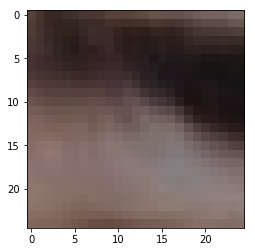

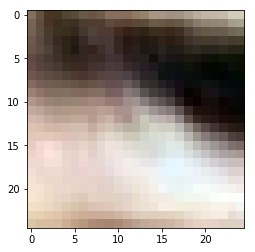

In [165]:
plt.imshow(GivenImage.astype(np.uint8))
plt.show()
plt.imshow(temp4.astype(np.uint8))
plt.show()